# MXNet + Transfer Learning
With TransferLearning Applied

[https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images](https://www.kaggle.com/maysee/mushrooms-classification-common-genuss-images)


In [2]:
# 1) download dataset
# 2) load into memory/convert to Torch dataset
# 3) choose transfer model -> resnet18 (44mb)
# 4) freeze original layers
# 5) add custom layers
# 6) train new layers added

In [1]:
!dir venv

zsh:1: command not found: dir


In [2]:
import torch
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

import pickle
from tqdm import tqdm
import os

In [3]:
class_names = ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe',
'Lactarius', 'Russula', 'Suillus']

In [4]:
# lets investigate whats inside:

! dir data\lab07\mushrooms

zsh:1: command not found: dir


In [5]:
import os
import shutil

def split_train_test(source_dir='./data/lab07/mushrooms', train_dir='./data/lab07-mushrooms-dataset/train', test_dir='./data/lab07-mushrooms-dataset/test'):
    for root, dirs, files in os.walk(source_dir):
        count = 0
        print(len(files))
        l = int(len(files)*0.2)
        for name in files:
            current_filepath = os.path.join(root, name)
            dataset_dir = train_dir if (l < count) else test_dir
            new_filepath = current_filepath.replace(source_dir, dataset_dir)
            try:
                os.makedirs(os.path.dirname(new_filepath))
            except FileExistsError:
                pass
            shutil.move(current_filepath, new_filepath)
            count += 1
    #shutil.rmtree(source_dir)




In [32]:
#split_train_test()

0
353
750
1073
836
364
316
1563
1148
311


In [76]:
import torchvision
from torchvision.transforms import v2

TRAIN_FOLDER = './data/lab07-mushrooms-dataset/train/'
TEST_FOLDER = './data/lab07-mushrooms-dataset/test/'

# see https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html for details
transforms = v2.Compose([
        v2.Resize(256),
        v2.CenterCrop(224),
        v2.ToTensor(),
        v2.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

train_dataset = torchvision.datasets.ImageFolder(root = TRAIN_FOLDER, transform = transforms)
test_dataset = torchvision.datasets.ImageFolder(root = TEST_FOLDER, transform = transforms)

In [35]:
print(len(train_dataset), len(test_dataset))

5029 1685


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: 0
Label description: Agaricus
<built-in method size of Tensor object at 0x150088b30>


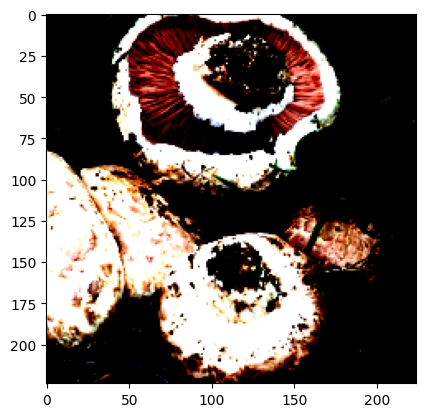

In [59]:
# show sample image, jusst to be sure, the dataset is working...

sample_idx = 32
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(np.array(data.permute(1, 2, 0)), cmap='gray')
print("Label: {}".format(label))
print("Label description: {}".format(train_dataset.classes[label]))
print(data.size)

In [50]:
print(np.array(data))

[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]


In [60]:
# setting device on GPU if available, else CPU

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


In [12]:
import torchvision.models as models

resnet18 = models.resnet18(weights='IMAGENET1K_V1')


In [13]:
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
# test model as is
image, label = test_dataset[56]
label = test_dataset.classes[label]

predicted_label = resnet18(image[None, :])
print(get_imagenet_label(predicted_label))

KeyError: tensor([[-6.9975e-01, -5.5350e-01, -7.0769e-01, -1.5941e+00, -8.5807e-01,
         -1.7954e-01, -5.4134e-01,  5.2804e-01,  4.1400e-01, -8.0594e-01,
         -1.0580e+00, -8.0618e-01, -4.1445e-01, -1.0767e+00, -1.1470e+00,
         -6.5677e-01, -8.5366e-01, -3.3834e-01, -4.9315e-01, -6.2446e-01,
         -1.5891e+00, -6.2942e-01, -1.3146e+00,  2.1851e-01, -8.3471e-01,
         -9.1616e-01, -7.3860e-01, -1.1491e+00, -8.0896e-01, -4.1876e-01,
         -9.2241e-01, -8.6452e-01, -5.4768e-01, -5.5924e-01, -3.6364e-01,
         -4.1273e-01,  5.8535e-01, -7.0922e-01, -4.5042e-01,  6.5120e-02,
         -7.0870e-01, -7.9366e-01, -1.0401e+00, -3.3277e-01, -6.0318e-01,
         -3.6521e-01, -7.9513e-01, -4.1645e-01, -1.1992e+00, -1.1211e+00,
         -4.2457e-01,  5.0208e-01, -2.5769e-01, -5.7229e-01, -1.1799e-01,
         -1.1791e+00, -3.1904e-01, -1.5126e+00, -5.3376e-01, -4.2535e-01,
          8.1271e-01,  1.6619e-01, -1.8237e-01,  1.6017e-01, -7.3913e-01,
         -1.9808e-01, -3.0907e-01, -3.7894e-01, -7.9954e-01, -9.3536e-01,
         -1.5087e+00,  1.6270e-01, -1.4155e+00, -2.7147e-01, -1.1226e+00,
         -1.3118e+00,  5.3954e-02, -5.6655e-01,  1.0592e-01,  2.0354e-01,
         -8.2120e-01, -1.6566e+00, -1.4623e-01, -7.1659e-01, -4.9450e-01,
         -1.2990e-01,  5.3701e-02,  3.6850e-01, -1.5960e-02, -6.6745e-01,
         -1.1905e+00, -1.1020e+00, -1.8967e+00, -2.1016e-01,  7.0280e-02,
         -2.1479e+00, -4.5319e-01, -4.1585e-01, -1.5745e+00, -3.9782e-01,
         -1.2387e+00, -9.6632e-01, -9.6841e-01, -3.3376e-01, -2.2087e-01,
         -7.3297e-01, -4.8182e-01, -1.2692e+00, -9.3033e-01, -1.4986e+00,
         -1.1658e+00, -4.4006e-01,  1.1399e+00,  3.8171e-01,  4.1843e-01,
         -1.0239e+00, -7.3984e-01, -2.1931e-01,  4.8918e-01, -3.7546e-01,
         -7.7441e-01, -3.8707e-02,  2.0753e-01,  8.1195e-02,  9.4156e-01,
         -1.5649e-01,  3.2671e-01, -1.4107e+00, -1.2101e+00, -1.2503e+00,
         -1.3802e+00, -1.5814e+00, -1.0645e+00, -1.4289e+00, -6.8395e-01,
         -1.3130e+00, -1.1042e+00, -1.1917e+00, -1.4357e+00, -1.6563e+00,
         -1.7377e+00, -1.9692e+00, -2.3232e+00, -1.6810e+00, -6.3865e-01,
         -3.7659e-01, -1.0037e+00, -1.8900e+00, -1.2381e+00, -1.3587e+00,
          3.1352e-01,  1.6639e+00, -9.5857e-01, -2.5588e-01,  2.0928e-02,
          1.0359e-01, -2.9262e-01, -2.0237e-01,  2.6135e-01,  2.2080e-01,
          3.4754e-01,  5.9390e-01,  3.2196e-01,  5.7347e-01,  4.2962e-01,
         -1.0576e-01, -1.1910e-01, -3.8894e-01,  5.7565e-01, -3.1746e-01,
         -1.2382e-01,  8.1384e-01,  3.9039e-01,  2.8406e-01,  2.3700e-01,
         -7.2651e-01,  1.2328e-01, -8.8453e-02,  6.0781e-01,  6.6042e-01,
          6.1873e-01, -2.8696e-02,  5.8263e-01,  1.4287e-01,  6.3344e-01,
          8.1852e-01,  6.7348e-01,  2.5284e-01,  2.0726e-01,  6.3756e-01,
         -4.8996e-01,  4.0040e-01,  3.8526e-01,  5.5265e-01, -6.2362e-01,
          8.1878e-01,  1.4755e-01,  2.3478e-01,  2.4893e-01,  6.8702e-01,
          1.2927e-01,  2.2248e-01,  6.5474e-01,  6.3525e-01,  1.5994e-01,
          2.6069e-01,  1.0079e-01,  6.3014e-01,  1.3710e+00,  4.8381e-01,
         -5.6804e-02,  3.6301e-01,  4.4040e-01,  1.0490e-02,  1.0541e-01,
          4.0423e-01, -4.5732e-02,  3.3837e-01, -3.3283e-01,  6.2501e-01,
          1.6534e-01, -8.3463e-02,  1.4949e-01,  7.9078e-01,  1.5801e-01,
          3.6473e-01,  1.5671e-01,  8.4355e-01, -3.3714e-01, -1.8114e-01,
         -1.2467e-01,  3.8474e-01,  4.5954e-01, -5.8364e-02,  9.0311e-01,
          7.7323e-01,  4.9607e-01,  4.6415e-01,  8.2030e-01, -2.3685e-02,
          6.7931e-01,  1.0331e-01,  4.1395e-01,  3.4530e-01, -2.9361e-01,
          3.7118e-01,  4.2316e-01, -2.7831e-02,  6.4612e-01,  2.0688e-01,
          4.6051e-01,  7.1511e-01, -7.8735e-01,  6.3550e-01,  9.6780e-01,
         -7.1372e-01,  3.8027e-01,  2.7997e-01, -1.0735e-01,  1.6587e-01,
         -3.1795e-01, -7.4426e-01, -2.1528e-01,  3.0844e-01,  6.4322e-01,
          8.2634e-01,  3.7769e-01,  5.8552e-01, -2.9733e-02, -4.6811e-01,
         -8.9235e-01, -1.0443e+00, -6.6293e-01,  6.6491e-01, -1.1521e+00,
         -1.0476e+00, -1.1286e+00, -8.9777e-01, -1.3018e+00, -6.1333e-01,
         -4.3538e-01,  8.0415e-01,  7.5129e-01, -6.7518e-02,  3.1598e-01,
          8.7966e-01, -3.1958e-01, -2.9690e-01, -7.3545e-01, -1.6307e+00,
         -1.0265e+00, -1.3241e+00, -4.4456e-01, -9.1516e-01, -1.0200e+00,
         -8.3981e-01, -1.0332e+00, -1.3904e+00, -3.7208e-01, -1.7129e-01,
         -1.9024e+00, -6.8058e-01, -3.8229e-01, -2.2895e-01, -1.0113e+00,
         -7.6214e-01,  1.7433e-01, -7.4031e-01, -1.3381e+00, -5.2668e-01,
          3.7165e-01, -4.0823e-01, -3.9966e-01,  3.2008e-01,  6.9740e-01,
         -5.3860e-01, -8.6405e-01, -1.2111e+00, -1.1035e+00, -7.0898e-01,
         -1.4842e+00, -1.1274e+00, -1.4547e+00, -1.6169e+00, -1.4872e+00,
         -1.6698e+00, -1.3370e+00,  1.1923e-02, -1.3645e-01, -4.8645e-01,
         -2.1921e-01, -3.5633e-01, -5.4913e-02,  1.6291e-01, -5.2911e-01,
         -8.6445e-01, -1.5740e+00,  6.2006e-02,  5.9486e-01, -1.1548e+00,
         -4.9903e-01,  5.4017e-01, -5.1291e-01, -1.4313e+00, -7.9684e-01,
          6.6262e-01, -7.5970e-01, -1.5443e+00, -1.4206e-01, -1.3276e+00,
         -1.0907e+00, -2.3675e+00, -1.4420e+00, -8.4372e-01, -6.1204e-01,
          4.3184e-01,  9.9718e-01, -1.2272e-03,  4.2651e-01,  3.4157e-01,
         -2.1681e-01,  4.8848e-01,  3.9285e-02,  2.8288e-01, -5.1044e-01,
         -5.3772e-01, -1.1633e+00, -3.9168e-01, -8.9660e-01, -6.5815e-01,
         -6.1251e-01, -3.0746e-01, -5.7940e-01, -1.1461e-01, -2.3467e-01,
         -9.3134e-01, -1.1252e+00,  2.9617e-01, -1.8625e-01, -5.2261e-01,
          2.9743e-01, -4.8025e-01, -2.7232e-01, -6.1977e-01, -7.7795e-01,
         -5.4881e-01, -1.0298e+00, -1.0285e+00, -9.0211e-01, -2.8874e-01,
          5.8725e-01, -3.7089e-02, -1.4171e+00, -1.6919e+00, -2.4576e-01,
          5.0932e-01, -1.0621e+00, -7.8861e-01,  4.3661e-01,  1.9050e-01,
         -7.2704e-01,  6.9205e-01,  2.2214e-01, -2.2303e+00, -1.9542e+00,
         -6.2100e-01, -2.1954e-01, -3.7821e-01, -2.9275e-01,  1.0463e+00,
         -1.3497e-01,  2.3274e-01,  2.0901e+00,  7.8289e-01,  4.6370e-01,
          8.8630e-01, -3.5644e-01,  3.2949e-01,  2.5025e-01,  9.4575e-01,
          8.0929e-01,  1.2802e+00, -2.2286e-01,  1.6949e-01, -2.8319e-02,
         -9.1742e-01, -4.7458e-02,  1.3736e+00,  1.7265e+00,  4.6317e-01,
         -8.0489e-01,  1.0364e-01,  2.5794e-01,  6.6048e-01,  3.8706e-01,
          9.4553e-01, -3.9129e-01, -3.8224e-01,  3.1772e-01,  3.4475e-01,
          7.6979e-01,  3.5714e-01,  1.5823e-01, -5.0618e-01, -2.4969e-01,
          1.9492e-01,  3.9214e-01,  1.4912e+00,  9.2093e-01, -6.0345e-01,
         -2.5626e-01,  4.5307e-01,  7.5647e-01, -7.2127e-02, -2.1418e-01,
          7.0113e-01,  1.5604e+00,  1.2173e+00, -4.6128e-02,  8.3782e-01,
         -7.3487e-01,  5.7889e-01,  1.2829e+00,  2.4178e+00,  9.6218e-01,
         -1.7604e-01, -1.2948e+00, -1.7898e-01, -7.1391e-02,  1.6505e+00,
          1.2219e+00,  6.6757e-01,  3.0057e-01,  8.6801e-01, -1.9836e-01,
          1.0925e-01,  1.0564e-01,  4.8675e-01,  7.4640e-01,  5.0535e-01,
         -7.5661e-02,  2.5657e-01,  4.2099e-01, -8.6345e-01, -1.5392e+00,
          2.1769e-02, -3.1881e-01,  1.2893e+00,  1.7835e+00,  1.1775e+00,
          5.8440e-01,  7.6079e-01,  7.6485e-01, -1.1521e+00,  1.2543e+00,
         -1.0211e+00, -4.3284e-02, -4.6853e-01, -3.3743e-01,  1.1629e+00,
         -1.4617e+00,  4.9602e-01,  1.2100e+00,  4.1807e-01,  9.6424e-01,
          1.1364e+00,  1.1628e+00,  6.3378e-01,  4.7209e-01,  2.7678e-01,
         -1.1662e+00, -8.6558e-01,  7.2953e-01,  2.6940e-01,  9.9972e-01,
          1.7860e+00,  4.1668e-01, -1.4137e-02,  1.3427e+00,  7.0800e-01,
         -7.2262e-01,  3.4196e-01,  1.0434e+00,  1.6763e+00,  3.4479e-01,
         -6.7694e-01, -6.5802e-02, -5.0379e-01,  4.5725e-01,  1.4003e-02,
          9.1811e-01,  2.7231e-01,  8.1852e-02, -8.8747e-01,  4.1272e-01,
         -5.7101e-01, -5.2332e-01, -6.1722e-01,  2.9529e-01,  1.2406e+00,
         -1.2856e+00,  1.5890e+00,  1.0699e+00,  7.4481e-01,  5.9955e-01,
          8.6561e-01,  5.8471e-01, -2.0984e+00, -1.2695e+00, -5.9998e-02,
         -4.6566e-01,  1.8091e-01,  6.9824e-01, -1.4141e-01, -1.6042e+00,
         -7.5649e-01,  4.0015e-01,  3.7848e-01,  1.2258e+00,  1.0022e+00,
         -4.2517e-02, -2.5237e-01,  8.8241e-01,  7.3677e-02, -1.1844e+00,
         -9.2701e-01,  1.6683e-01,  1.1048e+00,  4.2771e-01, -6.7700e-01,
          1.1440e+00,  6.1364e-02,  7.6061e-01, -8.6475e-01,  5.4893e-01,
         -1.9367e-01, -8.9537e-01,  1.1011e+00,  2.5116e-01,  2.0591e-01,
          2.9499e-01, -2.2000e-01,  7.4604e-01,  6.6174e-01,  9.8303e-01,
          7.0468e-01, -3.9314e-01,  1.6476e+00,  1.2605e+00,  1.2351e+00,
         -5.6658e-01,  5.2705e-01, -5.3952e-01,  7.4036e-01,  2.3659e-01,
         -6.8243e-01,  1.0058e+00, -2.2605e-01, -5.7965e-01,  9.8885e-01,
          2.1604e+00, -4.3189e-02, -2.1438e-01, -5.2439e-01,  6.2959e-01,
          2.3105e-01,  1.3999e+00, -5.3961e-01,  4.4525e-01, -3.3087e-02,
          9.2256e-01,  6.1489e-01, -5.0618e-01,  5.5863e-01,  2.2138e-02,
          3.0364e-01,  1.2716e+00,  4.5554e-01,  2.0112e+00,  9.3213e-01,
          9.5515e-01,  7.4384e-01,  3.9584e-01,  5.9017e-01,  6.0928e-02,
         -1.2317e+00,  1.0154e+00, -3.8715e-01, -1.2274e+00,  2.9304e-01,
          5.4080e-02,  8.9155e-01,  7.3969e-01,  1.1901e+00, -1.8527e-01,
          3.7460e-01,  1.3384e+00,  8.3678e-01,  6.5959e-01,  2.3757e-01,
         -1.6075e+00,  1.1612e+00,  3.4561e-02,  1.4198e+00,  8.8477e-01,
         -7.8741e-01,  6.4642e-01,  3.5127e-01, -7.1858e-01, -1.4864e+00,
          1.0850e+00,  2.2330e-01,  6.6976e-01,  8.3472e-01, -1.6028e-01,
          6.5753e-01, -8.4366e-02,  4.3840e-02,  6.0059e-02,  5.2167e-01,
         -1.6307e-01, -1.0232e+00, -2.7176e-02, -8.2555e-01,  8.5659e-01,
          6.6836e-02,  1.2753e+00,  4.3523e-01, -8.2386e-01, -4.3326e-01,
          2.6168e-01, -2.0243e-01, -1.9865e-01,  6.2845e-01,  1.4310e+00,
         -9.0509e-01,  1.6166e+00,  1.0774e+00,  1.0006e+00,  3.4254e-01,
          5.9163e-01,  5.2088e-01, -5.8123e-01,  4.7859e-01,  7.2401e-01,
         -1.4251e+00, -1.8740e-01, -1.1549e+00, -2.2323e-01, -7.6601e-01,
         -7.2724e-01,  8.9368e-01,  8.6495e-01,  7.1366e-01, -1.1038e+00,
          9.2721e-01,  1.5496e+00,  6.8113e-03, -3.2128e-01,  5.8297e-01,
          1.9388e+00, -2.5389e-01, -2.6968e-01,  5.0034e-01,  7.2475e-01,
         -5.8074e-01, -2.9958e-01,  3.7777e-01,  8.6583e-01,  1.9385e-01,
          1.0406e+00,  9.4091e-01,  1.3982e-01, -3.8905e-01,  4.9615e-01,
         -4.9682e-01,  7.7834e-01, -8.1020e-01, -4.0449e-01,  5.4769e-01,
          1.9649e-01,  2.5733e-01,  1.3401e+00,  2.3112e-01, -7.7103e-01,
          1.3256e+00, -6.8820e-01, -6.9404e-02,  1.3787e+00, -4.1135e-01,
          1.5757e-01,  2.1821e+00, -6.0052e-01,  1.7902e+00, -1.4934e+00,
          1.8036e-01, -4.6933e-02,  6.5407e-01,  9.7392e-01,  2.1091e-01,
          1.0699e+00, -6.9518e-02,  3.9749e-01,  3.5371e-01,  6.2445e-01,
          1.4532e-01,  7.8051e-02,  5.6411e-01,  8.1949e-01,  1.5664e+00,
          6.4452e-01, -1.7761e-01,  2.6958e-01,  6.9877e-01,  9.0497e-01,
         -5.5190e-01,  1.1869e+00, -2.0981e-01,  1.3574e+00, -7.3518e-02,
          1.2472e-01,  7.8005e-01,  4.0486e-01,  7.3150e-01,  1.3703e+00,
          8.7992e-01,  4.1745e-01,  5.0942e-01, -1.8220e-01,  1.2360e+00,
          4.4475e-01,  3.8230e-01,  1.5645e+00,  7.3193e-01,  8.6012e-01,
          3.2571e-01,  4.1496e-01,  5.9005e-01,  1.3039e+00, -8.4917e-01,
         -1.0724e+00, -7.8803e-01,  1.0074e+00,  8.1829e-01,  1.6538e+00,
          3.9264e-01,  5.1586e-01,  1.2043e+00,  2.3602e-01, -4.6677e-02,
          7.0134e-01,  1.0994e+00,  1.6282e+00,  9.5158e-01,  3.1486e-01,
          1.0429e-02,  1.0369e+00,  7.4957e-01, -7.5170e-01,  2.9108e-01,
         -8.2801e-01,  2.4053e-01, -1.1207e+00, -1.3733e+00,  1.0702e+00,
          1.2934e+00,  3.1843e-01,  3.2938e-01,  1.4056e+00,  9.5782e-02,
         -5.1829e-01,  1.1472e+00, -2.6638e-01,  1.6898e+00, -1.1476e+00,
         -1.8615e-01,  3.2264e-01, -1.1973e+00,  1.6482e+00,  3.2281e-01,
         -1.6824e+00, -9.6068e-01,  4.4759e-01,  7.9317e-01,  9.8265e-01,
         -8.0367e-01,  4.5105e-01,  9.0289e-01,  1.3833e+00, -6.9999e-01,
          1.1686e+00,  4.3201e-01, -5.9658e-01, -9.8405e-01,  7.6630e-02,
          6.0355e-01,  1.6191e+00,  1.6234e+00,  9.9187e-01, -5.2874e-01,
          1.3959e+00,  3.7563e-01,  4.1550e-01,  6.8313e-01,  6.0248e-01,
          1.6367e+00,  7.8012e-01, -4.0297e-01,  5.0760e-01,  1.0190e+00,
          1.3190e+00,  1.4086e+00,  1.8545e+00, -5.2514e-01, -3.2722e-01,
          8.4862e-01, -6.6792e-01, -1.1951e-01, -1.2821e-01,  9.7038e-01,
          1.1163e-01,  1.3849e+00,  1.0117e+00, -1.3498e-01, -4.8198e-01,
          6.2477e-01,  3.6502e-02, -5.0346e-01,  1.5505e+00, -4.9121e-01,
          9.0308e-01, -1.5285e+00,  1.1819e+00, -1.0020e+00, -2.3818e+00,
          2.9885e-01,  1.5697e+00, -1.6785e-01, -1.8699e-01,  1.7039e+00,
          1.1353e+00, -2.4977e-01,  1.1162e+00,  1.3325e+00,  1.9973e-01,
          2.4798e-01, -3.8765e-01, -3.9278e-01, -1.0284e+00,  3.3141e-01,
         -4.2790e-01,  3.5117e-01,  7.4991e-01,  1.3303e-01, -6.5816e-01,
         -7.5018e-01,  1.0877e+00,  6.7593e-01,  1.9924e+00,  1.9308e+00,
         -1.0621e+00, -5.0591e-01,  1.6943e+00,  9.3243e-01,  8.5974e-01,
          1.1291e-01, -5.0579e-01,  1.2661e+00, -9.3418e-01,  1.0132e+00,
          1.3544e+00,  1.1614e+00,  8.3058e-01, -4.8033e-01, -1.9486e+00,
         -3.7210e-01,  1.6540e-01,  2.9887e-01,  5.8677e-01,  8.8214e-02,
         -1.2292e-01,  1.1073e+00, -6.4088e-01,  6.6107e-01, -2.1862e-01,
         -8.9761e-01, -9.8072e-01, -4.9688e-01, -1.2465e-01,  1.3915e+00,
         -2.7135e-01,  1.4022e-02,  4.2706e-01, -1.6509e+00, -6.1082e-02,
         -4.9852e-01,  3.8598e-01,  2.6904e-01,  2.5653e-02,  1.1508e-03,
         -2.8770e-01, -6.3432e-01, -2.5883e-01,  2.3940e-01, -5.8771e-01,
         -7.4025e-01, -1.2647e+00,  5.4605e-01,  7.3976e-01, -3.3806e-01,
          5.7697e-02, -4.5325e-01, -4.7202e-01,  1.4901e-01,  8.4792e-01,
         -3.9804e-01, -2.3185e-01, -6.1474e-01, -8.4350e-02, -9.4293e-01,
          4.0938e-01,  2.5643e-01, -2.9154e-01, -7.8403e-01, -1.1726e+00,
         -2.3849e-01,  3.9565e-01, -6.2488e-01,  8.3366e-01,  3.4614e-03,
          3.6392e-02,  1.0534e+00, -2.8089e-01, -4.0092e-01, -2.1441e+00,
          9.6872e-01, -1.4877e+00,  4.4286e-01,  2.6159e-01, -7.2256e-01,
         -6.3063e-01,  1.0797e-02,  4.9398e-01, -4.2406e-01, -9.6635e-01,
         -1.1898e+00, -2.2142e+00,  1.4134e+00, -2.2252e-01, -8.7130e-01,
         -1.9364e-01, -1.1487e+00, -8.8435e-01, -1.9465e+00, -7.7245e-01,
         -3.4397e-01,  2.3021e-01, -5.4401e-01,  1.2790e+00,  1.0549e+00]],
       grad_fn=<AddmmBackward0>)

In [17]:
predicted_label

tensor([[-6.9975e-01, -5.5350e-01, -7.0769e-01, -1.5941e+00, -8.5807e-01,
         -1.7954e-01, -5.4134e-01,  5.2804e-01,  4.1400e-01, -8.0594e-01,
         -1.0580e+00, -8.0618e-01, -4.1445e-01, -1.0767e+00, -1.1470e+00,
         -6.5677e-01, -8.5366e-01, -3.3834e-01, -4.9315e-01, -6.2446e-01,
         -1.5891e+00, -6.2942e-01, -1.3146e+00,  2.1851e-01, -8.3471e-01,
         -9.1616e-01, -7.3860e-01, -1.1491e+00, -8.0896e-01, -4.1876e-01,
         -9.2241e-01, -8.6452e-01, -5.4768e-01, -5.5924e-01, -3.6364e-01,
         -4.1273e-01,  5.8535e-01, -7.0922e-01, -4.5042e-01,  6.5120e-02,
         -7.0870e-01, -7.9366e-01, -1.0401e+00, -3.3277e-01, -6.0318e-01,
         -3.6521e-01, -7.9513e-01, -4.1645e-01, -1.1992e+00, -1.1211e+00,
         -4.2457e-01,  5.0208e-01, -2.5769e-01, -5.7229e-01, -1.1799e-01,
         -1.1791e+00, -3.1904e-01, -1.5126e+00, -5.3376e-01, -4.2535e-01,
          8.1271e-01,  1.6619e-01, -1.8237e-01,  1.6017e-01, -7.3913e-01,
         -1.9808e-01, -3.0907e-01, -3.

In [15]:
def get_imagenet_label(prediction_idx):

    with open("./data/lab07-mushrooms-dataset/imagenet1000_clsidx_to_labels.txt") as f:
        idx2label = eval(f.read())

    return idx2label[prediction_idx]


In [18]:
def show(image):
    plt.figure()
    plt.imshow(np.array(image.permute(1, 2, 0)))
    plt.show()

In [19]:
def predict_imagenet (model, image, k):
    prediction = model(image[None, :])
    
    top = torch.topk(prediction, k=k)
    print(top)

    for index, probability in zip(top.indices[0], top.values[0]):
        label = get_imagenet_label(index.item())
        print("{}: {:.2f}".format(label, probability.item()))

def predict (model, image, classes, k):
    prediction = model(image[None, :])
    
    top = torch.topk(prediction, k=k)
    print(top)

    for index, probability in zip(top.indices[0], top.values[0]):
        label = classes[index.item()]
        print("{}: {:.2f}".format(label, probability.item()))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.return_types.topk(
values=tensor([[2.6097, 2.1975, 2.1259]], grad_fn=<TopkBackward0>),
indices=tensor([[463, 731, 600]]))
bucket, pail: 2.61
plunger, plumber's helper: 2.20
hook, claw: 2.13


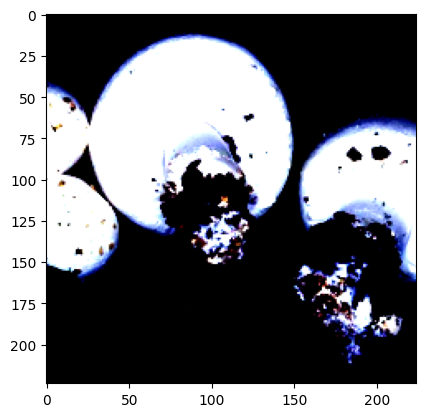

In [20]:
image, _ = test_dataset[0]

predict_imagenet(resnet18, image, 3)
show(image)

In [21]:
for param in resnet18.parameters():
    param.requires_grad = False

In [22]:
# Parameters of newly constructed modules have requires_grad=True by default
num_features = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_features, 9)

resnet18 = resnet18.to(device)

# print new model
print(resnet18)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [72]:
import torchvision.models as models

OUT_FEATURES = 9

def build_model():
    #model = models.resnet18(weights='IMAGENET1K_V1')
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    
    for param in model.parameters():
        param.requires_grad = False
        
    def init_weights(m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0.01)
        
    # Parameters of newly constructed modules have requires_grad=True by default
    #num_features = model.fc.in_features
    model.fc = nn.Linear(model.fc.in_features, OUT_FEATURES)
        
        #nn.Sequential(
        #nn.Linear(num_features, OUT_FEATURES)
        #nn.Linear(num_features, 1024),
        #nn.ReLU(),
        #nn.Linear(1024, 512),
        #nn.ReLU(),
        #nn.Linear(512, 64),
        #nn.ReLU(),
        #nn.Linear(64, OUT_FEATURES)
    #))
    
    model.fc.apply(init_weights)
    
    return model


In [73]:
print(build_model())

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [70]:
# define a train function, model-agnostic, which will be used for further training
def train(net, train_loader, device, num_epochs, learning_rate):
    
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    loss_function = torch.nn.CrossEntropyLoss()
    acc_history = []

    with tqdm(total=len(train_loader)*num_epochs, position=0, leave=True) as pbar:

        for epoch in range(num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0 
            
            for batch_num, (inputs, labels) in enumerate(train_loader):
                # Possibly copy inputs and labels to the GPU
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                # Forward pass
                outputs = net(inputs)
                loss = loss_function(outputs, labels)

                # Backpropagation                
                loss.backward()

                # Update
                optimizer.step()

                # Print progress
                running_loss += loss.item()

                # Calculate batch Accuracy
                _, predicted = outputs.max(1)
                batch_total = labels.size(0)
                batch_correct = predicted.eq(labels).sum().item()
                batch_acc = batch_correct/batch_total
                
                pbar.set_description("Epoch: %d, Batch: %2d, Loss: %.2f, Acc: %.2f" % (epoch, batch_num, running_loss, batch_acc))
                pbar.update()

                total += batch_total
                correct += batch_correct

            # Print the evaluation metric and reset it for the next epoch
            acc = correct/total 
            acc_history.append(acc)

        pbar.close()

    return acc_history


def print_history(history, title):
    plt.figure(figsize=(7, 4))
    plt.plot(history)
    plt.title(title)
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

In [77]:
# prepare training
BATCH_SIZE = 32
EPOCHS = 10
LR = 0.005

resnet_transfer = build_model()
resnet_transfer = resnet_transfer.to(device)

train_dataloader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True)

hist = train(resnet_transfer, train_dataloader, device, EPOCHS, LR)

Epoch: 7, Batch: 52, Loss: 36.35, Acc: 0.78:  73%|███████▎  | 1159/1580 [1:37:08<35:17,  5.03s/it]   


KeyboardInterrupt: 

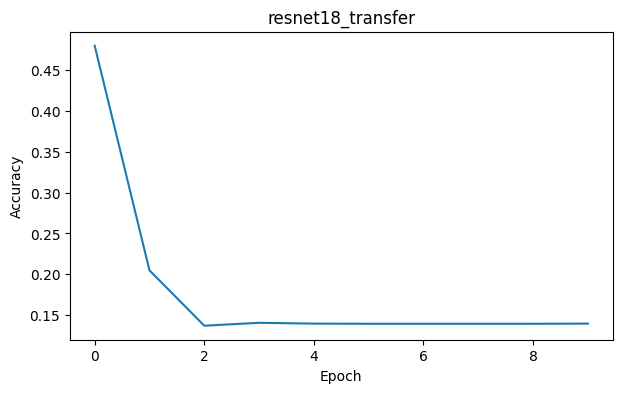

In [28]:
print_history(hist, 'resnet18_transfer')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.return_types.topk(
values=tensor([[1.2228, 1.0642, 0.2157]], grad_fn=<TopkBackward0>),
indices=tensor([[6, 7, 2]]))
Lactarius: 1.22
Russula: 1.06
Boletus: 0.22


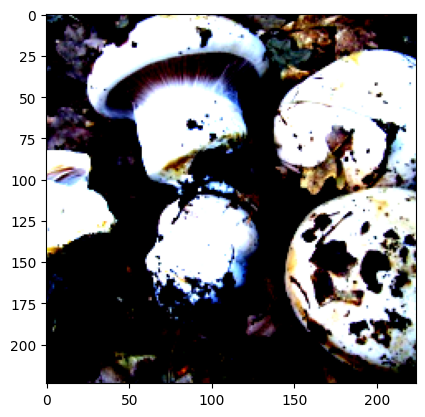

True label:  Cortinarius


In [30]:
image, label = test_dataset[654]

predict(resnet_transfer, image, test_dataset.classes, 3)
show(image)
print('True label: ', test_dataset.classes[label])